In [1]:
import pandas as pd
from sklearn import datasets
import openensembles as oe
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score as sil
from sklearn.metrics import calinski_harabaz_score as ch

import random

import seaborn as sns
sns.set()
%config InlineBackend.figure_format ='retina'

In [2]:
# x, _ = datasets.make_moons(n_samples=250, shuffle=True, noise=0.03, random_state=42) 
x, _ = datasets.make_blobs(n_samples=250, centers=3,n_features=2, random_state=30) 
df = pd.DataFrame(x).rename(columns={0:"x", 1:"y"})

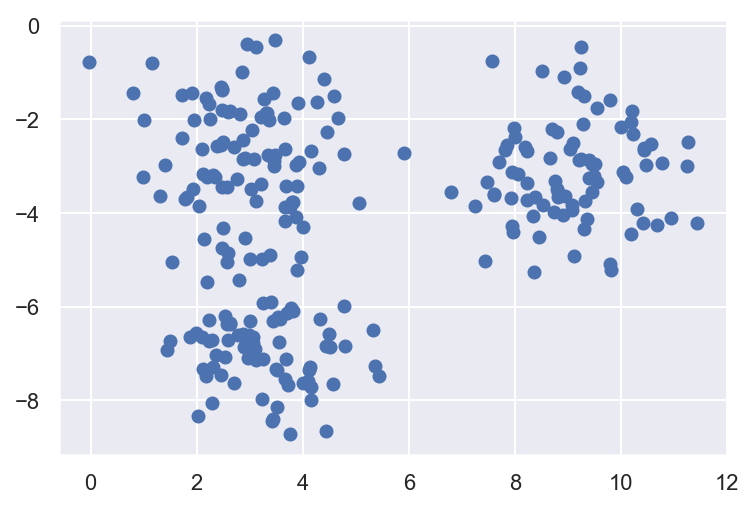

In [3]:
plt.scatter(df.x, df.y);

### regular k-means

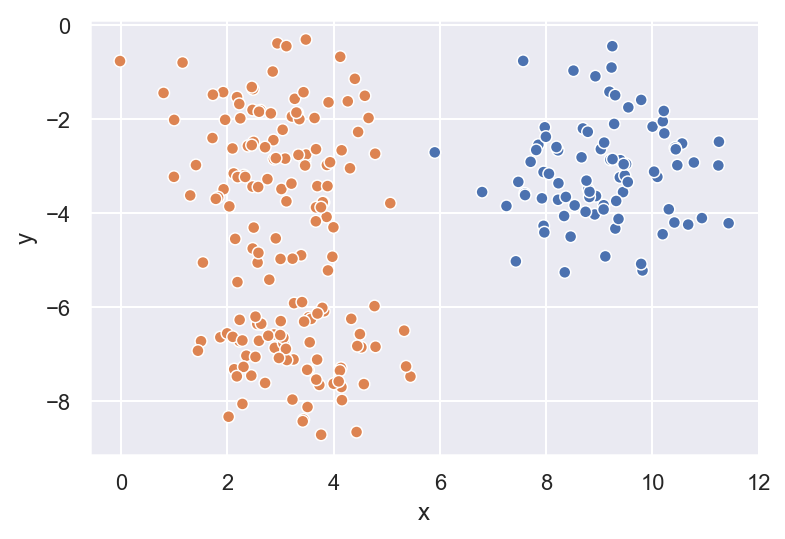

In [4]:
labels_kmeans = KMeans(n_clusters=2).fit_predict(df)
sns.scatterplot(data=df, x=df.x, y=df.y, hue=labels_kmeans, legend=False)


### Ensemble k-means (Fred, 2001)

In [5]:
#instantiate the oe data object
dataObj = oe.data(df, [1,2])

#instantiate an oe clustering object
c = oe.cluster(dataObj)
c_MV_arr = []
val_arr = []

for i in range(20):
    # add a new clustering solution, with a unique name
    name = f'kmeans_{i}'
    c.cluster('parent', 'kmeans', name, K=10, init = 'random', n_init = 1)
    
    # calculate a new majority vote solution, where c has one more solution on each iteration 
    c_MV_arr.append(c.finish_majority_vote(threshold=0.5))
    
    #calculate the determinant ratio metric for each majority vote solution
    v = oe.validation(dataObj, c_MV_arr[i])
    
    val_name = v.calculate('det_ratio', 'majority_vote', 'parent') 
    val_arr.append(v.validation[val_name])
    
    
#calculate the co-occurrence matrix
coMat = c.co_occurrence_matrix()

/Users/f.dobrykh/opt/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/f.dobrykh/opt/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


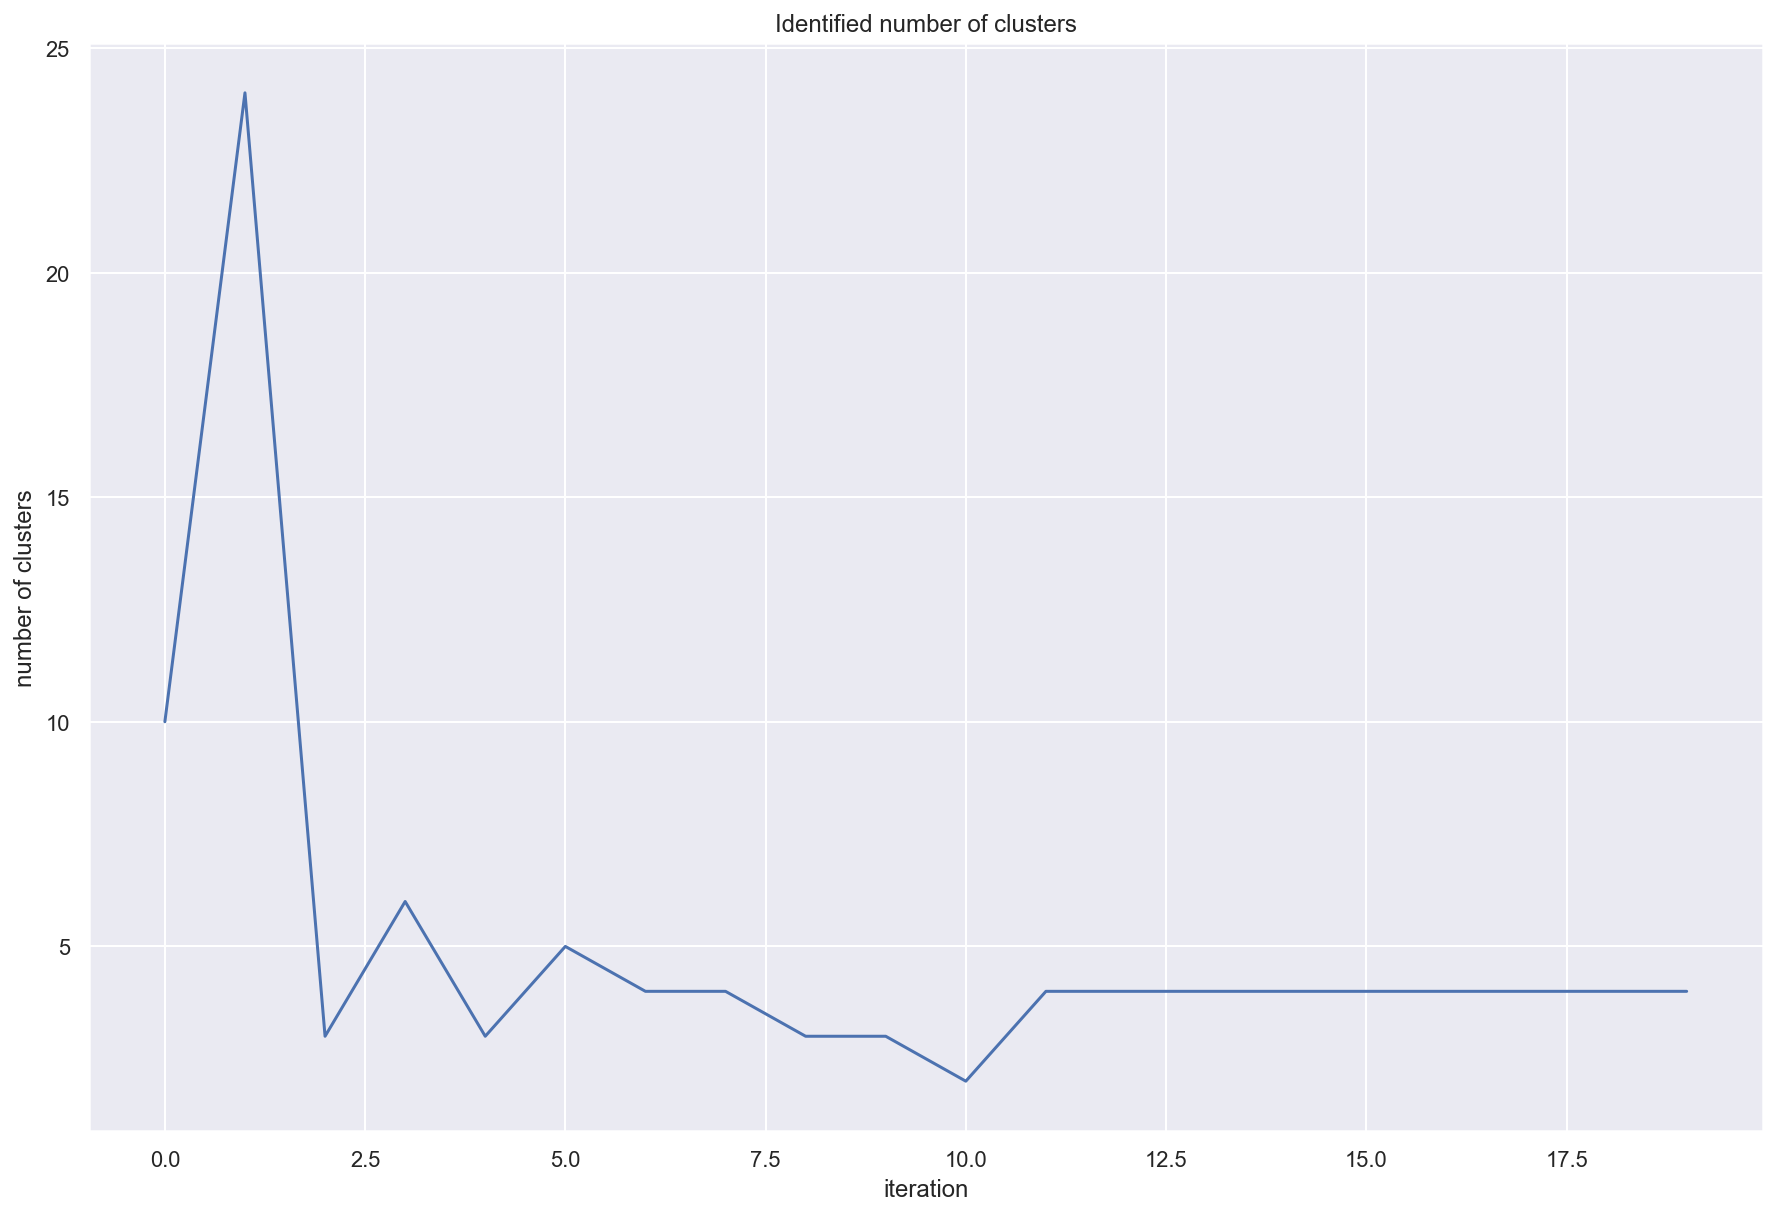

In [7]:
k_list = list(map(lambda x: len(x.clusterNumbers['majority_vote']), c_MV_arr))

plt.figure(figsize=(15, 9.9999))
plt.title("Identified number of clusters")
plt.xlabel("iteration")
plt.ylabel("number of clusters")
sns.lineplot(x=[i for i in range(len(k_list))], y=k_list)
# plt.savefig("Fred, identified K", dpi=300)

In [9]:
labels = c_MV_arr[9].labels['majority_vote']

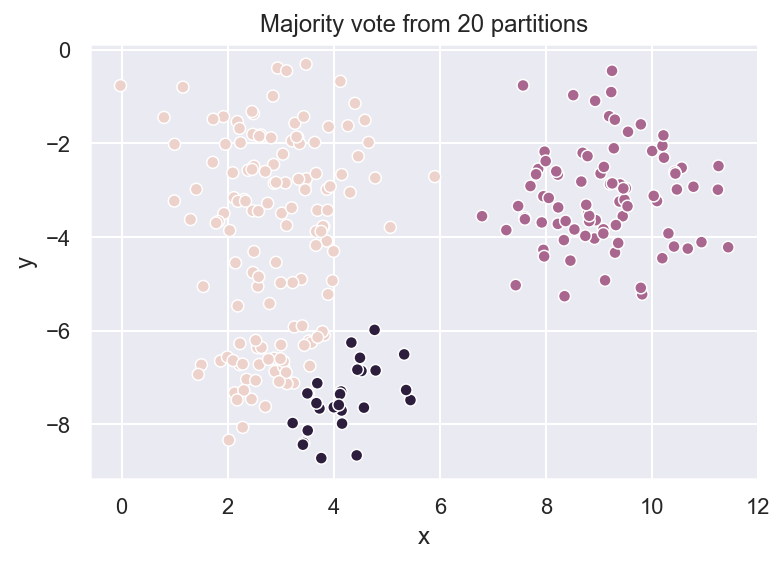

In [11]:
plt.title("Majority vote from 20 partitions")
sns.scatterplot(data=df, x=df.x, y=df.y, hue=labels, legend=False)
plt.savefig("pics/somedata", dpi=300)

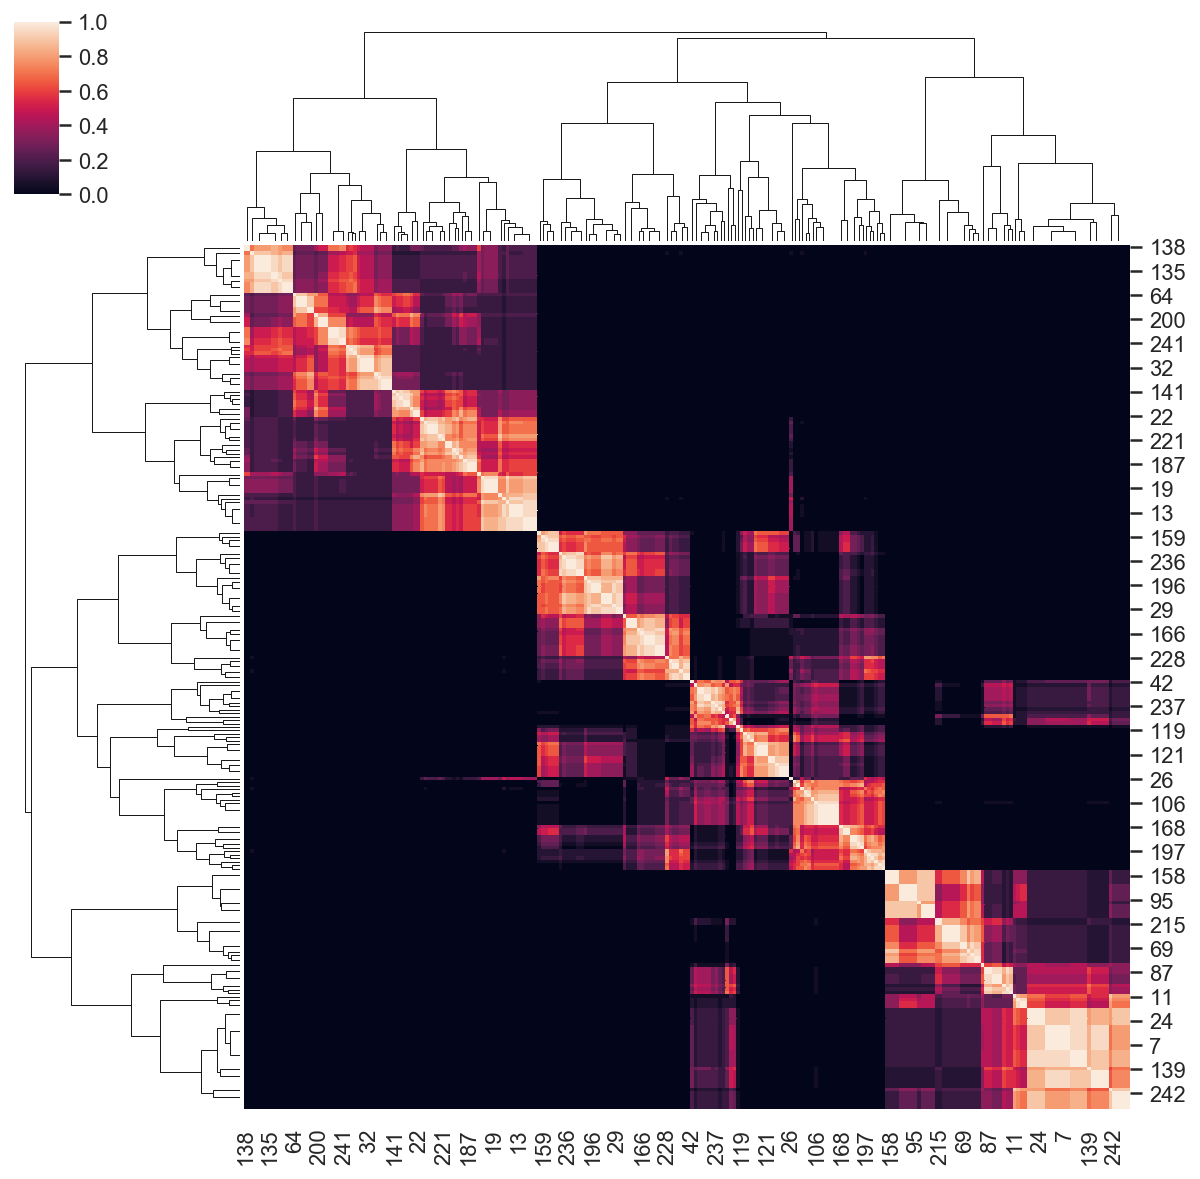

In [12]:
sns.clustermap(coMat.co_matrix)
plt.savefig("pics/clustermap", dpi=300)

### Experiment

In [13]:
def experiment_majority_vote(df):
    dataObj = oe.data(df, [1,2])

    c = oe.cluster(dataObj)
    c_MV_arr = []
    val_arr = []

    for i in range(20):
        name = f'kmeans_{i}'
        c.cluster('parent', 'kmeans', name, K=10, init = 'random', n_init = 1)
        c_MV_arr.append(c.finish_majority_vote(threshold=0.5))
        v = oe.validation(dataObj, c_MV_arr[i])
        val_name = v.calculate('det_ratio', 'majority_vote', 'parent') 
        val_arr.append(v.validation[val_name])

    coMat = c.co_occurrence_matrix()
    return c_MV_arr, val_arr, coMat


def experiment_graph_closure(df):
    dataObj = oe.data(df, [1,2])

    c = oe.cluster(dataObj)
    c_MV_arr = []
    val_arr = []

    for i in range(20):
        name = f'kmeans_{i}'
        c.cluster('parent', 'kmeans', name, K=10, init = 'random', n_init = 1)
        c_MV_arr.append(c.finish_graph_closure(threshold=0.5))
        v = oe.validation(dataObj, c_MV_arr[i])
        val_name = v.calculate('det_ratio', 'graph_closure', 'parent') 
        val_arr.append(v.validation[val_name])

    coMat = c.co_occurrence_matrix()
    return c_MV_arr, val_arr, coMat

def test_k_convergence_mv(df, n_runs=30):
    results = {}
    validations, cms = [], []

    for i in range(n_runs):
        res, val, cm = experiment_majority_vote(df)
        results[i] = list(map(lambda x: len(x.clusterNumbers['majority_vote']), res))
        
    data = pd.DataFrame(results)
    data = pd.melt(data.assign(index=data.index), id_vars=['index'])
    data.rename(columns={"index": "iteration", "variable": "run", "value": "k"}, inplace="true")
    
    return data

def test_k_convergence_gc(df, n_runs=30):
    results = {}
    validations, cms = [], []

    for i in range(n_runs):
        res, val, cm = experiment_graph_closure(df)
        results[i] = list(map(lambda x: len(x.clusterNumbers['graph_closure']), res))
        
    data = pd.DataFrame(results)
    data = pd.melt(data.assign(index=data.index), id_vars=['index'])
    data.rename(columns={"index": "iteration", "variable": "run", "value": "k"}, inplace="true")
    
    return data

#### Datasets

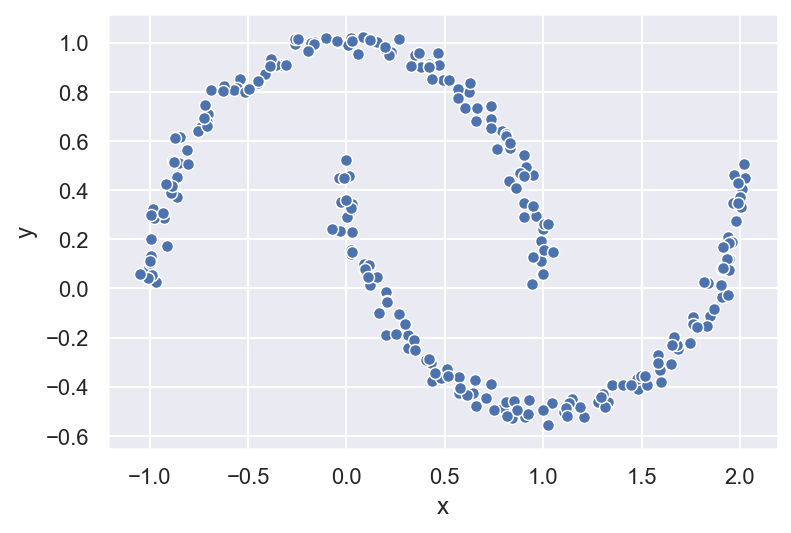

In [15]:
x, _ = datasets.make_moons(n_samples=250, shuffle=True, noise=0.03, random_state=42) 
moons = pd.DataFrame({"x": x[:, 0], "y": x[:, 1]})
sns.scatterplot(data=moons, x=moons.x, y=moons.y)

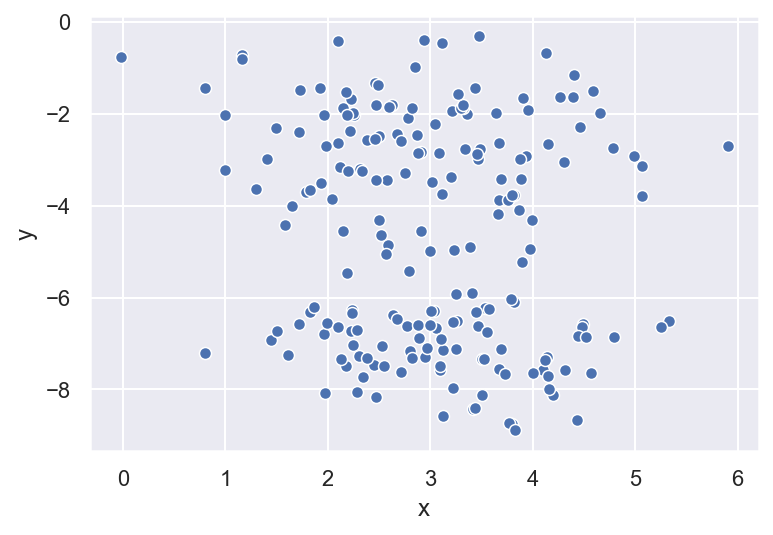

In [18]:
x, _ = datasets.make_blobs(n_samples=200, centers=2, n_features=2, random_state=30)
blobs = pd.DataFrame({"x": x[:, 0], "y": x[:, 1]})
sns.scatterplot(data=blobs, x=blobs.x, y=blobs.y)

#### kmeans

In [19]:
labels_blobs = KMeans(n_clusters=2).fit_predict(blobs)
labels_moons = KMeans(n_clusters=2).fit_predict(moons)

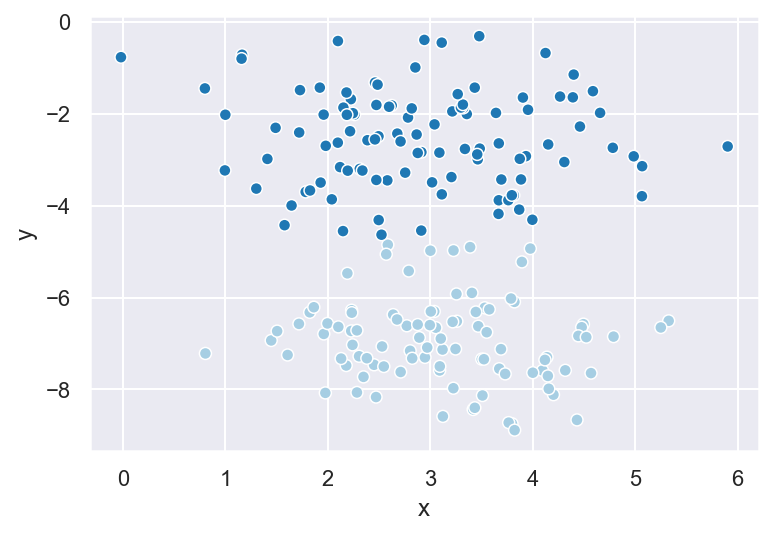

In [20]:
sns.scatterplot(data=blobs, x=blobs.x, y=blobs.y, hue=labels_blobs, legend=False, palette="Paired")
# plt.savefig("pics/kmeans blobs.png", dpi=300)

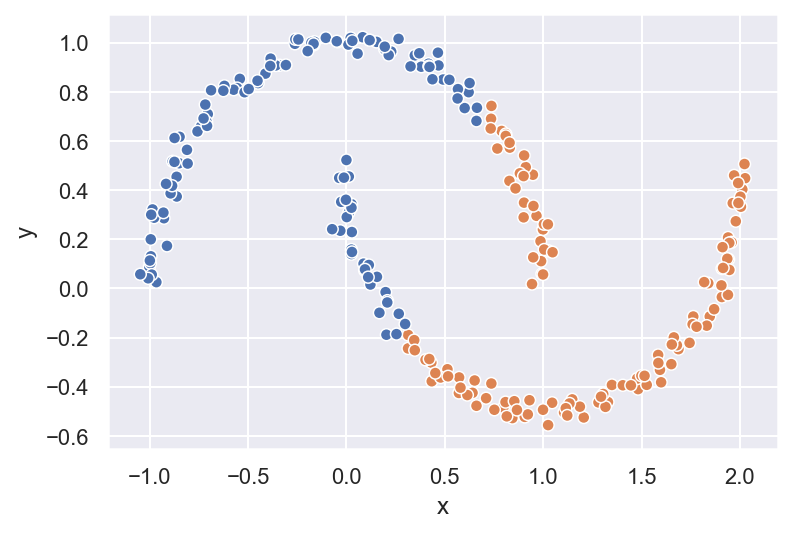

In [21]:
sns.scatterplot(data=moons, x=moons.x, y=moons.y, hue=labels_moons, legend=False)
# plt.savefig("kmeans moons.png", dpi=300)

In [22]:
print(sil(blobs, labels_blobs))
print(sil(moons, labels_moons))
print(ch(blobs, labels_blobs))
print(ch(moons, labels_moons))

0.60227302607
0.493800089621
504.3984334
376.680952699


#### Majority voting

In [23]:
mvs_blobs, val, cm = experiment_majority_vote(blobs)

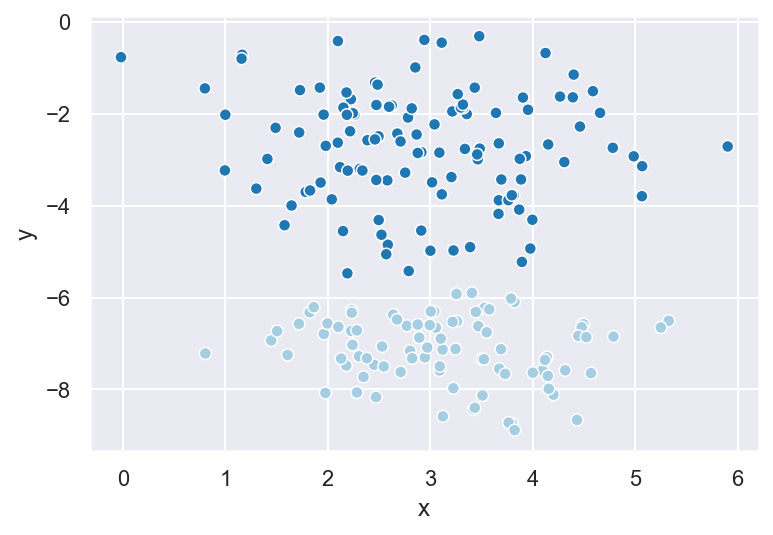

In [24]:
labels_mvs_blobs = mvs_blobs[-6].labels['majority_vote']
labels_mvs_blobs = list(map(lambda x: 0 if x == 1 else 1, labels_mvs_blobs))
sns.scatterplot(data=blobs, x=blobs.x, y=blobs.y, hue=labels_mvs_blobs, legend=False, palette="Paired")
plt.savefig("pics/mv blobs.png", dpi=300)

In [25]:
mvs_moons, _, _ = experiment_majority_vote(moons)

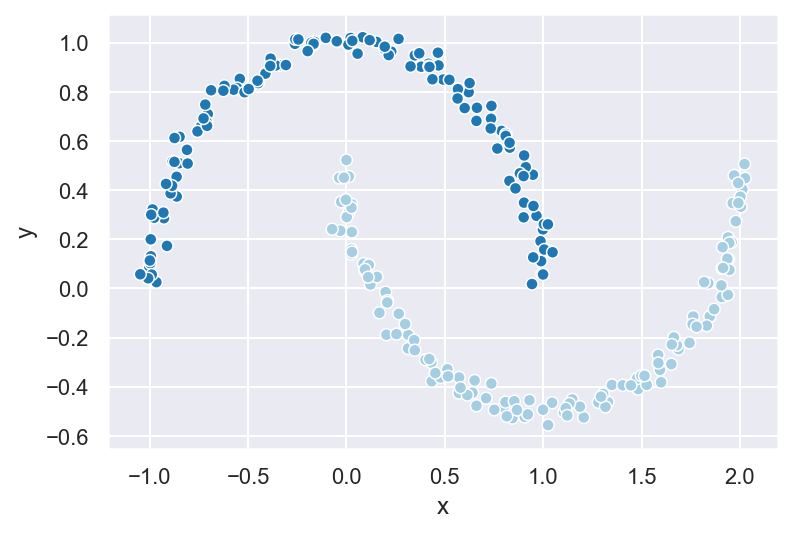

In [27]:
labels_mvs_moons = mvs_moons[-1].labels['majority_vote']  # [{},{},{labels:[]}]
labels_mvs_moons = list(map(lambda x: 0 if x == 1 else 1, labels_mvs_moons))
sns.scatterplot(data=moons, x=moons.x, y=moons.y, hue=labels_mvs_moons, legend=False, palette="Paired");
# plt.savefig("pics/mv moons.png", dpi=300)


In [28]:
print(sil(blobs, labels_mvs_blobs))
print(sil(moons, labels_mvs_moons))
print(ch(blobs, labels_mvs_blobs))
print(ch(moons, labels_mvs_moons))

0.589708302311
0.327608695356
468.664170188
161.193439118


In [29]:
conv_mv = test_k_convergence_mv(blobs)

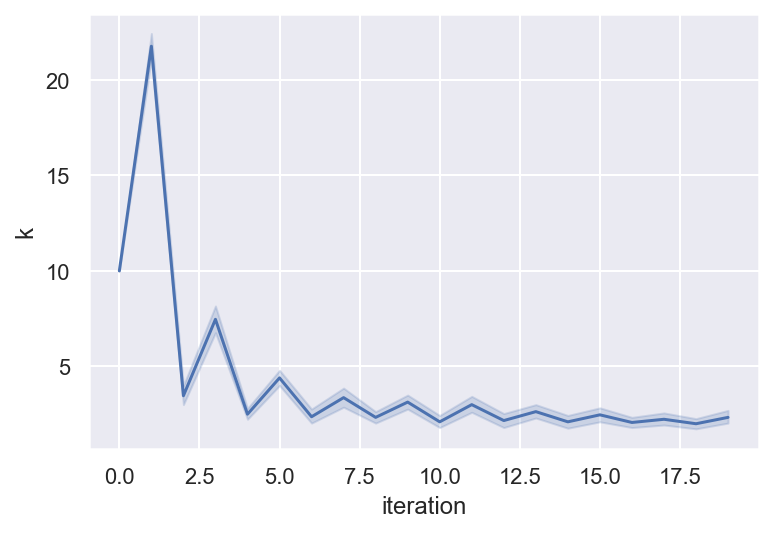

In [30]:
sns.lineplot(data=conv_mv, x=conv_mv.iteration, y=conv_mv.k)

NameError: name 'conv_mv_moons' is not defined

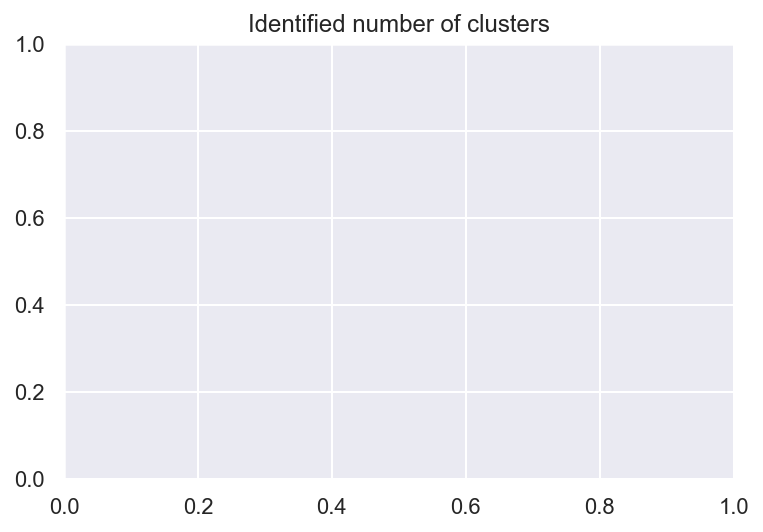

In [31]:
conv_mv_moons = test_k_convergence_mv(moons)
plt.title("Identified number of clusters")
sns.lineplot(data=conv_mv_moons, x=conv_mv_moons.iteration, y=conv_mv_moons.k)
plt.savefig("pics/mv k.png", dpi=300)

#### Graph closure

In [ ]:
gcs_moons, _, _ = experiment_graph_closure(moons)

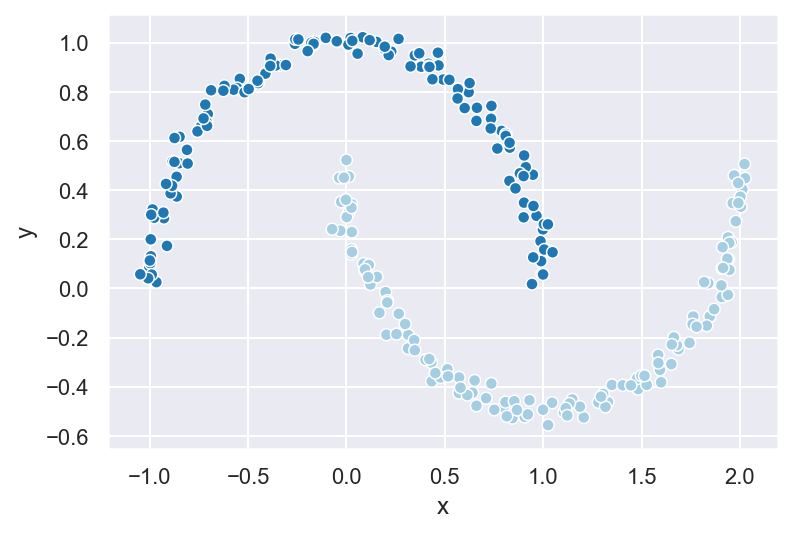

In [280]:
sns.scatterplot(data=moons, x=moons.x, y=moons.y, hue=gcs_moons[-1].labels['graph_closure'], legend=False, palette="Paired")
plt.savefig("pics/gc moons.png", dpi=300)

In [262]:
gcs_blobs, _, _ = experiment_graph_closure(blobs)

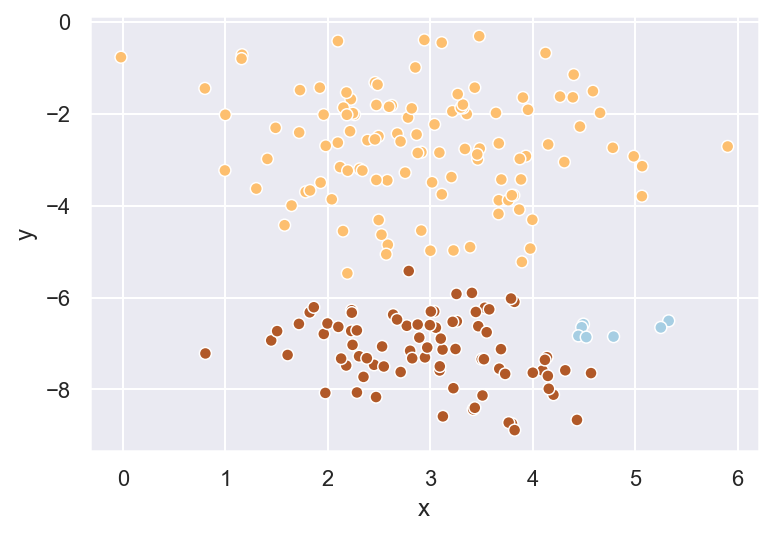

In [311]:
gcs_blobs_labels = gcs_blobs[-3].labels['graph_closure']

sns.scatterplot(data=blobs, x=blobs.x, y=blobs.y, hue=gcs_blobs_labels, legend=False, palette="Paired")
plt.savefig("pics/gc blobs.png", dpi=300)

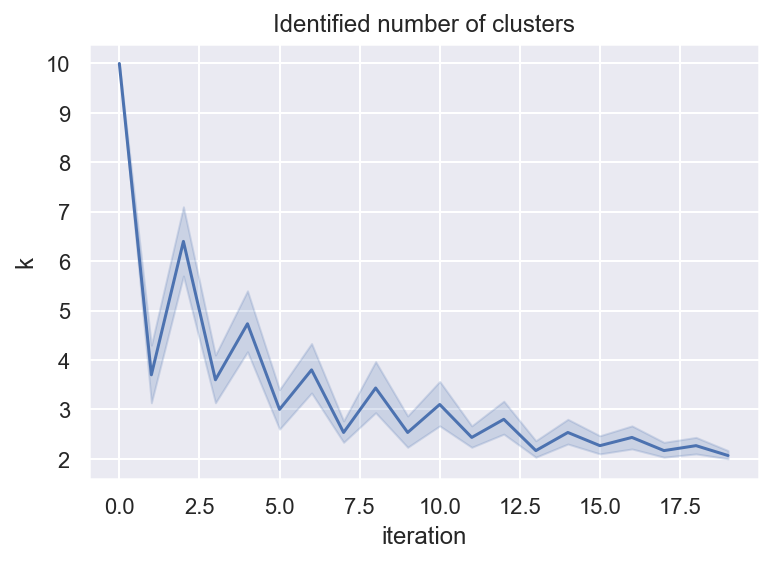

In [314]:
# conv_gc_moons = test_k_convergence_gc(moons)
plt.title("Identified number of clusters")
sns.lineplot(data=conv_gc_moons, x=conv_gc_moons.iteration, y=conv_gc_moons.k)
plt.savefig("pics/gc k.png", dpi=300)

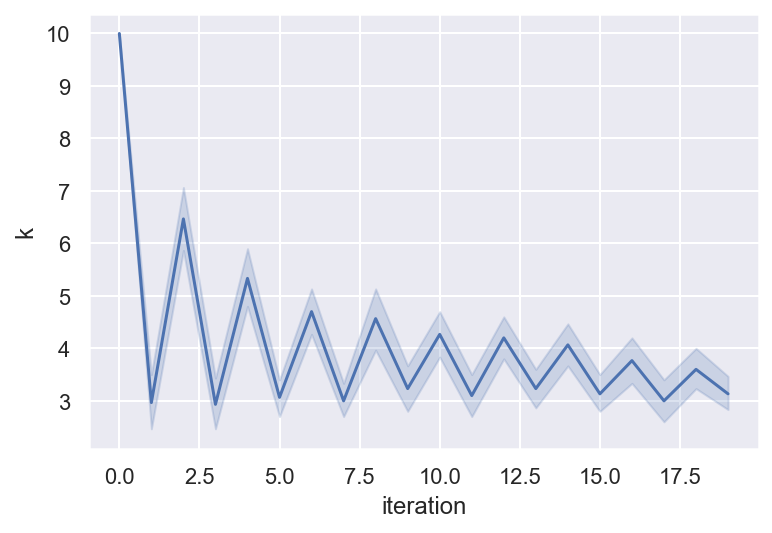

In [220]:
conv_gc_blobs = test_k_convergence_gc(blobs)
sns.lineplot(data=conv_gc_blobs, x=conv_gc_blobs.iteration, y=conv_gc_blobs.k)